In [1]:
import time
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Парсер для получения данных с westmetall
def parser(metall_str: str):
    url = f'https://www.westmetall.com/en/markdaten.php?action=table&field=LME_{metall_str}_cash'
        
    response = requests.get(url=url)
    
    # преобразуем ответ в датафрейм
    df_2023 = pd.read_html(response.text)[0]
    df_2022 = pd.read_html(response.text)[1]
    df_2021 = pd.read_html(response.text)[2]
    df_2020 = pd.read_html(response.text)[3]
    df_2019 = pd.read_html(response.text)[4]
    df_2018 = pd.read_html(response.text)[5]
    df_2017 = pd.read_html(response.text)[6]
    df_2016 = pd.read_html(response.text)[7]
    df_2015 = pd.read_html(response.text)[8]
    df_2014 = pd.read_html(response.text)[9]
    df_2013 = pd.read_html(response.text)[10]
    
    df = pd.concat([
        df_2023, df_2022, df_2021, 
        df_2020, df_2019, df_2018, 
        df_2017, df_2016, df_2015,
        df_2014, df_2013
    ]
    )
    
    # очищаем таблицу от неинформативных строк
    cleared_df = df[df['date'] != 'date']
    # заменяем символы пропусков нулями
    cleared_df = cleared_df.replace('-', 0)
    
    # приобразуем типы данных
    cleared_df['date'] = pd.to_datetime(cleared_df['date'])
    # т.к. столбцы имеют разное назание, обращяемся по индексу
    cleared_df.iloc[:,1] = pd.to_numeric(
        cleared_df.iloc[:,1])

    cleared_df.iloc[:,2] = pd.to_numeric(
        cleared_df.iloc[:,2])
    # в данном столбце, за счет использования символа запятой
    # для разделения целой части от дробной,
    # pandas не корректно преобразовал значения
    cleared_df.iloc[:,3] = pd.to_numeric(
        cleared_df.iloc[:,3]) / 1000
    
    return cleared_df.set_index('date')

# Список источников, нам понадобится информация по 5 видам сырья:
# алюминий, медь, свинец, никель и цинк
metalls = ['Al', 'Cu', 'Pb', 'Ni', 'Zn']

# Иниуиируем датафреймы, делая паузу после исполнения, для обхода
# возможной блокировки со стороны источника
al_df = parser(metalls[0])
time.sleep(1)
cu_df = parser(metalls[1])
time.sleep(1)
pb_df = parser(metalls[2])
time.sleep(1)
ni_df = parser(metalls[3])
time.sleep(1)
zn_df = parser(metalls[4])


# Выведем полученные данные и сохраним как бекап.
al_df.to_csv('./data/aluminium.csv', sep=',')
cu_df.to_csv('./data/copper.csv', sep=',')
pb_df.to_csv('./data/lead.csv', sep=',')
ni_df.to_csv('./data/nickel.csv', sep=',')
zn_df.to_csv('./data/zink.csv', sep=',')

display(cu_df.head(), cu_df.head())

----

In [1]:
# Блок предподготовки полученных данных
# Обработка данных полученных с lme
data_lme = pd.read_csv('./data/copper.csv', parse_dates=['date'], index_col='date')
data_lme = data_lme.sort_index()


NameError: name 'pd' is not defined

In [78]:


# Обработка данных полученных с nasdaq
data_nasdaq = pd.read_csv('./data/HGCMX.csv', parse_dates=['date'], index_col='date')
data_nasdaq.drop(['Unnamed: 0'], inplace=True, axis=1)
data_nasdaq = data_nasdaq['volume']

# Объединение данных источников с проведением дневной интерполяции
data = pd.merge(data_lme, data_nasdaq, left_index=True, right_index=True)
# Удаление ошибки
data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)
# Переименовывание столбцов
data.rename(columns={'volume': 'NASDAQ_volume', 'LME Copper stock': 'LME_stock'}, inplace=True)
data = data.resample('d').interpolate(method='linear')
# Произведем сдвиг LME Copper 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену меди для операций сроком на 3 месяца. 
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data['LME Copper 3-month'] = data['LME Copper 3-month'].shift(90)

data.tail()

,LME Copper Cash-Settlement,LME Copper 3-month,LME_stock,NASDAQ_volume
date,,,,
2023-08-12,8242.0,8314.333333,85.058333,84.398333
2023-08-13,8242.0,8334.000000,85.216667,77.890667
2023-08-14,8242.0,8129.000000,85.375000,71.383000
2023-08-15,8126.5,8209.000000,90.150000,28.615000
2023-08-16,8132.0,8217.000000,90.875000,24.828000


Text(0.5, 1.0, 'Матрица корреляций для признаков')

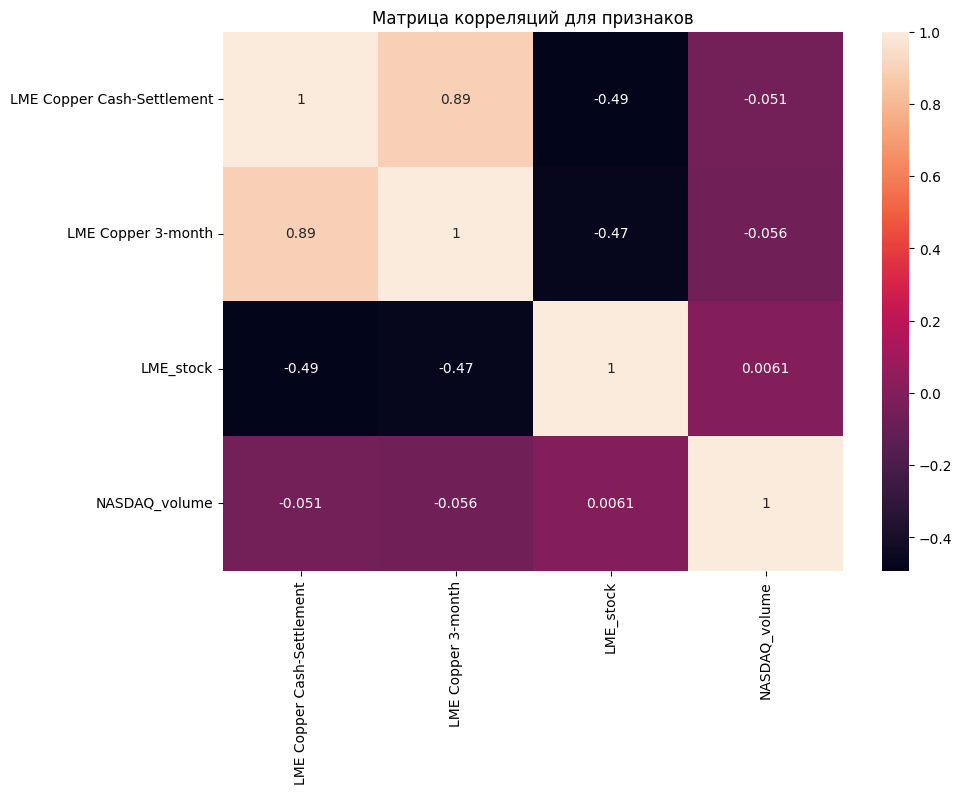

In [79]:
# Проверим корреляцию признаков
fig, axes = plt.subplots(1, 1, figsize=(10, 7))
heatmap = sns.heatmap(data=data.corr(), annot=True,ax=axes)
heatmap.set_title('Матрица корреляций для признаков')